# Advanced Classification - Day 6 - Exercises

## Exercise 1

#### Question 1 
##### Load libraries that are used in this module.

In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD, model_selection

#### Question 2 
##### Set `main_dir` to the location of your `af-werx` folder.
##### Make `data_dir` from the `main_dir` and concatenate remainder of the path to data directory.

In [2]:
nb_root=globals()['_dh']
os.chdir(nb_root[0])

main_dir = os.path.abspath(os.path.join ("..",))

# Make `data_dir` and 'path_dir' from the `main_dir` and
data_dir = os.path.join(main_dir, "data")
plot_dir = os.path.join(main_dir, "plot")

# Set working directory.
os.chdir(data_dir)
# Check working directory.
print(os.getcwd())



/Users/datasociety/Desktop/af-werx/data


#### Question 3
##### Set the working directory to data_dir.
##### Check if the working directory is updated to `data_dir'.

In [3]:
print('see above')

see above


#### Question 4
##### Read in 'lastfm_ratings.csv' dataset to a dataframe named 'fm_ratings' and 'lastfm_artists.csv' as 'fm_artists'.
##### Print the info and head of the dataset.

In [4]:
fm_ratings = pd.read_csv('lastfm_ratings.csv')
fm_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68314 entries, 0 to 68313
Data columns (total 5 columns):
userID         68314 non-null int64
artistID       68314 non-null int64
rating         68314 non-null float64
artist_name    68314 non-null object
genre          68314 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.6+ MB


In [5]:
fm_ratings.head()

,userID,artistID,rating,artist_name,genre
0,4,51,4.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
1,27,51,2.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
2,28,51,1.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
3,62,51,7.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
4,63,51,7.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...


In [6]:
fm_artists = pd.read_csv('lastfm_artists.csv')
fm_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11065 entries, 0 to 11064
Data columns (total 3 columns):
artistID       11065 non-null int64
artist_name    11065 non-null object
genre          11065 non-null object
dtypes: int64(1), object(2)
memory usage: 259.4+ KB


In [7]:
fm_artists.head()

,artistID,artist_name,genre
0,51,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
1,52,Morcheeba,chillout| downtempo| electronic| trip-hop| fem...
2,53,Air,electronic| autumn| downtempo| electronic| tri...
3,54,Hooverphonic,relax| electronic| female vocalist| trip-hop| ...
4,55,Kylie Minogue,seen live| electronic| pop| dance| pop dance| ...


#### Question 5
##### Print a word cloud to find which words are repeated in the artist name using fm_artists dataframe.

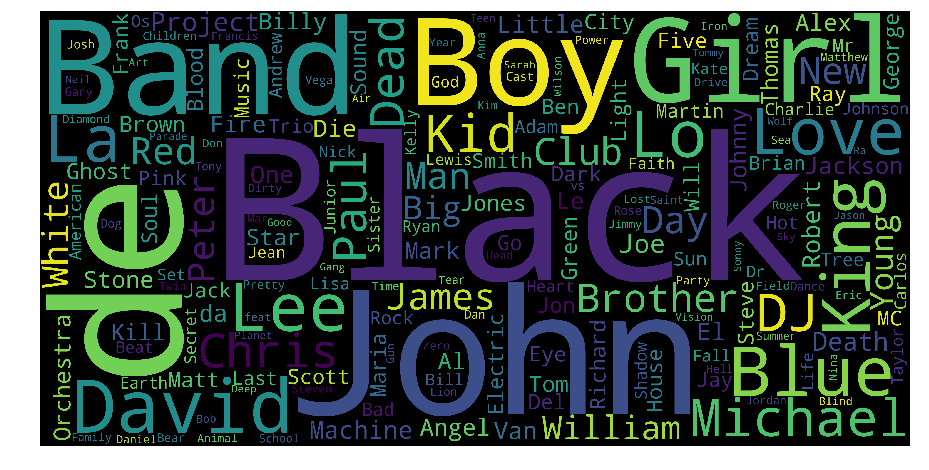

In [8]:
# Create a word cloud of the movie titles.
fm_artists['artist_name'] = fm_artists['artist_name'].fillna("").astype('str')
title_corpus = ' '.join(fm_artists['artist_name'])
title_wordcloud = WordCloud(stopwords = STOPWORDS,
                            background_color = 'black',
                            height = 2000, 
                            width = 4000).generate(title_corpus)

# Plot the word cloud.
plt.figure(figsize = (16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()


#### Question 6
##### Find the distribution of rating by plotting a count plot in fm_ratings dataframe.

count    68314.000000
mean         3.830898
std          2.318058
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64


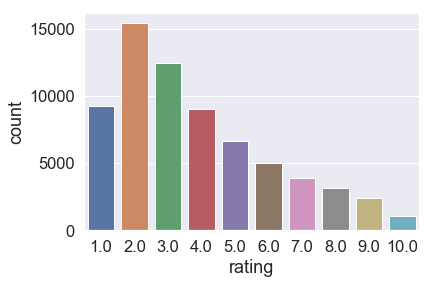

In [9]:
# Get summary statistics of ratings.
print(fm_ratings['rating'].describe())
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of ratings.
sns.countplot(fm_ratings['rating'])

#### Question 7
##### Fetch all the genres in the dataset and print top 5 using the function we used in the module.

In [10]:
# Join all 3 files into one dataframe.
#dataset =  pd.merge(pd.merge(fm_artists, fm_ratings), right = 'artistID')
#dataset = fm_artists.join(fm_ratings.set_index('artistID'), on='artistID')
# Display 5 movies with highest ratings.
#print(dataset[['artist_name', 'genres', 'rating']].sort_values('rating', ascending = False).head(5))
# Make a census of the genre keywords.
genre_labels = set()
for s in fm_artists['genre'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [11]:
type(genre_labels)

set

In [12]:
# Function that counts the number of times each of the genre keywords appear.
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1

    # Convert the dictionary in a list to sort the keywords by frequency.
    keyword_occurrences = []
    for k,v in keyword_count.items():
        keyword_occurrences.append([k,v])
    keyword_occurrences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurrences, keyword_count

In [13]:
keyword_occurrences, dum = count_word(fm_artists, 'genre', genre_labels)
print(keyword_occurrences[:5])

[[' rock', 6754], [' alternative', 4882], [' pop', 4679], [' indie', 4078], [' electronic', 4025]]


#### Question 8
##### Find the word cloud for the genres to see which genres are listed more frequently.

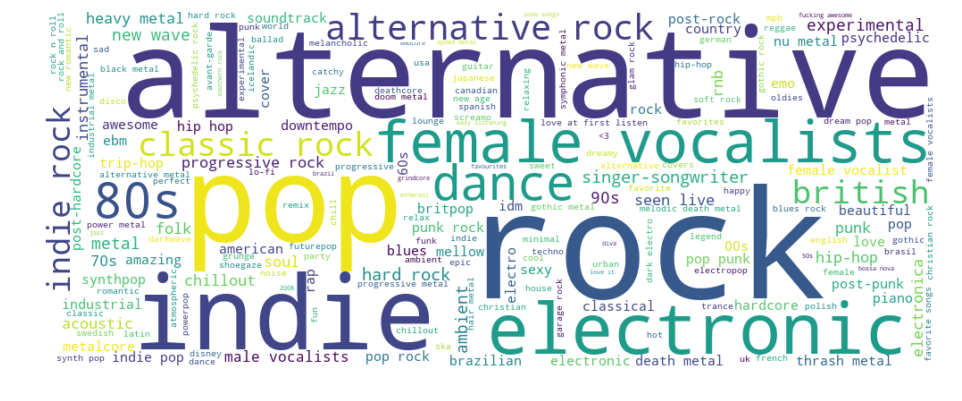

In [14]:
# Define the dictionary used to produce the genre word cloud.
genres = dict()
trunc_occurrences = keyword_occurrences[:]
for s in trunc_occurrences:
    genres[s[0]] = s[1]

# Create the word cloud.
genre_wordcloud = WordCloud(width = 1000, height = 400, background_color = 'white')
genre_wordcloud.generate_from_frequencies(genres)


# Plot the word cloud.
f, ax = plt.subplots(figsize = (16, 8))
plt.imshow(genre_wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()


### Exercise 2

#### Question 1
##### We will build a content based recommender system using `fm_artists` dataframe.
##### Convert the genre to string array.
##### Calculate the TF-IDF matrix.

In [15]:
# Break up the big genre string into a string array.
fm_artists['genre'] = fm_artists['genre'].str.split('|')

# Convert genres to string values.
fm_artists['genre'] = fm_artists['genre'].fillna("").astype('str')
print(fm_artists['genre'].head())
tf = TfidfVectorizer(analyzer = 'word',
                     ngram_range = (1, 2),
                     min_df = 0,
                     stop_words = 'english')

tfidf_matrix = tf.fit_transform(fm_artists['genre'])
print(tfidf_matrix.shape)


0    ['new wave', ' 80s', ' new wave', ' 80s', ' ne...
1    ['chillout', ' downtempo', ' electronic', ' tr...
2    ['electronic', ' autumn', ' downtempo', ' elec...
3    ['relax', ' electronic', ' female vocalist', '...
4    ['seen live', ' electronic', ' pop', ' dance',...
Name: genre, dtype: object
(11065, 52490)


#### Question 2
##### Build the cosine similarity of the artists, call it 'cosine_sim', and print the top entries in that matrix.
##### Also, print the shape of the cosine similarity matrix.
##### Build the list of artists' titles, and label it 'indices'.

In [16]:
tfidf_matrix

<11065x52490 sparse matrix of type '<class 'numpy.float64'>'
	with 293341 stored elements in Compressed Sparse Row format>

In [17]:
# Cosine similarity for all artist, and look at the first four rows and columns.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim[:4, :4])

print(cosine_sim.shape)

# Build a 1-dimensional array with movie titles.
titles = fm_artists['artist_name']
indices = pd.Series(fm_artists.index, index = fm_artists['artist_name'])
print(titles[0:5])


[[1.         0.01875779 0.04932386 0.02676505]
 [0.01875779 1.         0.43918315 0.82512665]
 [0.04932386 0.43918315 1.         0.47910804]
 [0.02676505 0.82512665 0.47910804 1.        ]]
(11065, 11065)
0      Duran Duran
1        Morcheeba
2              Air
3     Hooverphonic
4    Kylie Minogue
Name: artist_name, dtype: object


#### Question 3
##### Use the function to return top similar artists based on the cosine similarity value for any given artist name.
##### Find recommendations for a person who likes 'Rihanna' in their playlist.
##### Also, find recommendations for someone who likes 'Madonna'.

In [18]:
# Function that get artists recommendations based on the cosine similarity score of artists.
def artist_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    artist_indices = [i[0] for i in sim_scores]
    return titles.iloc[artist_indices]

In [19]:
print(artist_recommendations('Rihanna').head(20))

219                  Ciara
200                Beyoncé
742        Destiny's Child
249     The Pussycat Dolls
224                 Fergie
217                 Cassie
190          Janet Jackson
427     Nicole Scherzinger
204         Jennifer Lopez
4922        Jessica Mauboy
409           Gwen Stefani
4580          Brick & Lace
197     Christina Aguilera
215          Nelly Furtado
201              Sugababes
507                 Hadise
9296                 Honey
4            Kylie Minogue
34               Lady Gaga
167           Mariah Carey
Name: artist_name, dtype: object


In [20]:
print(artist_recommendations('Madonna').head(20))

4            Kylie Minogue
241                   Cher
34               Lady Gaga
507                 Hadise
9296                 Honey
194         Britney Spears
409           Gwen Stefani
197     Christina Aguilera
190          Janet Jackson
354                  Ke$ha
2066                 Robyn
193                Rihanna
1693             September
222            Hilary Duff
799               t.A.T.u.
407          Lindsay Lohan
205             Katy Perry
3667           Paula Abdul
215          Nelly Furtado
279                Cascada
Name: artist_name, dtype: object


### Exercise 3

#### Question 1
##### Transform the fm_ratings with userID as the row and artist_name as the column and the rating as the value. Set it as "userRating".
##### Find the correlation matrix for the artist_name. Do not use min_periods as we did in module, since our dataset is small here.
##### It could take a lot of time to form the correlation matrix, so you can also load from our data_dir where we already have it calculated and saved.
##### Load "corrMatrix_ex.csv" as corrMatrix - also, set the first column `artist_name` as the index for the dataframe.
##### Hint: df = df.set_index('artist_name')

In [21]:
userRating = fm_ratings.pivot_table(index = ['userID'],
                                   columns = ['artist_name'],
                                   values = 'rating')

print(userRating.shape)
userRating.head()

(1836, 11065)


artist_name,(hed) Planet Earth,*NSYNC,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,1-800-ZOMBIE,10 Years,100 Bitches,100DEADRABBITS!!!,...,Башня Rowan,МакSим,Мультfильмы,Розовые Очки От Ferre,Розовые очки от ferre,аутside,℃-ute,けちゃっぷmania,月島きらり starring 久住小春(モーニング娘。),雅-MIYAVI-
userID,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#corrMatrix = userRating.corr(method = 'pearson')
#corrMatrix.to_csv('corrMatrix_ex.csv', index = True, encoding = 'utf-8')

os.chdir(data_dir)
corrMatrix = pd.read_csv('corrMatrix_ex.csv')

print(corrMatrix.head())

corrMatrix = corrMatrix.set_index('artist_name')


                                    artist_name  (hed) Planet Earth  *NSYNC  \
0                            (hed) Planet Earth                 1.0     NaN   
1                                        *NSYNC                 NaN     1.0   
2            ...And The Earth Swarmed With Them                 NaN     NaN   
3  ...And You Will Know Us by the Trail of Dead                 NaN     NaN   
4                                   .38 Special                 NaN     NaN   

   ...And The Earth Swarmed With Them  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

   ...And You Will Know Us by the Trail of Dead  .38 Special  .crrust  \
0                                           NaN          NaN      NaN   
1                                           NaN          NaN      NaN   
2                                           NaN          Na

#### Question 2
##### We will find recommendations for userID 25. Assign user_id as 25 and use the same steps we did in the module to find the artist recommendation.
##### First, create a list of all artists with all correlations multiplied by rating.
##### Group by artist_id and sum the ratings to remove the duplicates.

In [35]:
def return_user_recomendations(user_id):
    user_corr = pd.Series()

    # Create a list of all artists with all correlations multiplied by the rating.
    for artist in userRating.iloc[user_id].dropna().index:
        corr_list = corrMatrix[artist].dropna() * userRating.iloc[user_id][artist]
        user_corr = user_corr.append(corr_list)

    # Group by movie ID and sum the ratings to remove duplicates.
    user_corr = user_corr.groupby(user_corr.index).sum()
    
    # Create a list of song the user has already seen and remove them.
    artist_list = []

    for i in range(len(userRating.iloc[user_id].dropna().index)):
        if userRating.iloc[user_id].dropna().index[i] in user_corr:
            artist_list.append(userRating.iloc[user_id].dropna().index[i])
        else:
            pass

    user_corr = user_corr.drop(artist_list)
    
    print('\n I would suggest that you listen to: \n')

    for i in user_corr.sort_values(ascending = False).index[:10]:
        print(i)
    
    print('\n Based on the artists you have listened to: \n')

    for i in userRating.iloc[user_id].dropna().index:
        print(i)

In [36]:
user = int(input("Enter your user ID: ")) 
return_user_recomendations(user)

Enter your user ID: 9

 I would suggest that you listen to: 

Cobra Starship
System of a Down
Ciara
Fergie
Goldfrapp
Yeah Yeah Yeahs
Kelly Rowland
The Cure
Linkin Park
Jonas Brothers

 Based on the artists you have listened to: 

Adam Lambert
Alanis Morissette
Alphabeat
Ashley Tisdale
Avril Lavigne
Beyoncé
Cheryl Cole
Christina Aguilera
David Guetta
Ellie Goulding
Evanescence
Fall Out Boy
Flo Rida
Good Charlotte
Gossip
Gwen Stefani
Hilary Duff
Jeffree Star
Jennifer Lopez
Katy Perry
Ke$ha
Kid Cudi
Kings of Leon
Kylie Minogue
La Roux
Lil' Wayne
Lily Allen
Lindsay Lohan
Little Boots
Madonna
Maroon 5
Miley Cyrus
Nelly Furtado
Nicole Scherzinger
No Doubt
Oasis
P!nk
Paramore
Paul van Dyk
Pitty
Pixie Lott
Placebo
Sophie Ellis-Bextor
Space Cowboy
Taio Cruz
Taylor Swift
The Pussycat Dolls
The Ting Tings
The Used


In [ ]:
user_corr = pd.Series()

user_id = 27

# Create a list of all films with all correlations multiplied by the rating.
for film in userRating.iloc[user_id].dropna().index:
    corr_list = corrMatrix[film].dropna() * userRating.iloc[user_id][film]
    user_corr = user_corr.append(corr_list)

# Group by movie ID and sum the ratings to remove duplicates.
user_corr = user_corr.groupby(user_corr.index).sum()



#### Question 3
##### Find the list of artists that the user has already heard and remove them.
##### Give top 10 recommendations.

In [61]:
fm_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68314 entries, 0 to 68313
Data columns (total 5 columns):
userID         68314 non-null int64
artistID       68314 non-null int64
rating         68314 non-null float64
artist_name    68314 non-null object
genre          68314 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.6+ MB


In [40]:
# Find total number of unique users and artist .
n_users = fm_ratings.userID.unique().shape[0]
n_artists = fm_ratings.artistID.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_artists))

Number of users = 1836 | Number of movies = 11065


### Exercise 4

#### Question 1
##### Find the total number of users and artists.
##### Transform our fm_ratings dataset using pivot_table where we have 1 row per user and 1 column per artist.

In [7]:
# Find total number of unique users and artist .
n_users = fm_ratings.userID.unique().shape[0]
n_artists = fm_ratings.artistID.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_artists))

Number of users = 1836 | Number of movies = 11065


#### Question 2
##### Convert the pivot table into matrix and find the sparsity percentage.

In [8]:

Ratings = fm_ratings.pivot(index = 'userID',
                        columns = 'artistID',
                        values = 'rating').fillna(0)
Ratings.head()


artistID,1,2,3,4,5,6,7,8,9,10,...,18719,18721,18722,18723,18724,18737,18739,18740,18741,18744
userID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
warnings.filterwarnings("ignore", category = FutureWarning)
# Normalize the data.
R = Ratings.as_matrix()

user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Check the percentage of sparsity.
sparsity = round(1.0 - len(fm_ratings) / float(n_users * n_artists), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')



The sparsity level of MovieLens1M dataset is 99.7%


In [16]:
R = Ratings.as_matrix()

In [17]:
user_ratings_mean.shape

(1836,)

In [20]:
user_ratings_mean[:4]

array([0.0068685 , 0.01816539, 0.01554451, 0.00388613])

In [34]:
user_ratings_mean.reshape(-1,3).shape

(612, 3)

In [32]:
user2[:4]

array([[0.0068685 , 0.01816539],
       [0.01554451, 0.00388613],
       [0.01256213, 0.01870764],
       [0.01816539, 0.01608676]])

#### Question 3
##### Fetch the first 50 latent features and return the list of artists the user has already rated.


In [36]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

# Convert the sigma matrix to the diagonal matrix form.
sigma = np.diag(sigma)

In [37]:
sigma

array([[ 60.72495494,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  60.86456559,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  61.02082531, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 122.45011535,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        179.233688  ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 241.87866921]])

In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)



In [48]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18719,18721,18722,18723,18724,18737,18739,18740,18741,18744
0,0.007284,0.002137,0.005183,0.004242,0.004230,0.001238,-0.075847,-0.001194,-0.007429,0.005201,...,0.007793,0.007793,0.007793,0.007793,0.007793,0.010560,0.009471,0.009471,0.008927,0.008927
1,0.046128,0.105739,-0.020564,0.030255,-0.010390,-0.019251,-0.283393,0.185779,0.132054,0.023294,...,-0.005091,-0.005091,-0.005091,-0.005091,-0.005091,-0.009523,-0.008847,-0.008847,-0.008508,-0.008508
2,0.043913,-0.058395,0.006666,0.014857,-0.035397,0.036515,0.621666,0.033331,-0.071096,-0.071283,...,-0.006928,-0.006928,-0.006928,-0.006928,-0.006928,-0.015935,-0.013086,-0.013086,-0.011662,-0.011662
3,0.005726,0.000141,0.000836,0.001847,0.005236,-0.002575,-0.021770,0.005871,0.003249,-0.001754,...,0.003492,0.003492,0.003492,0.003492,0.003492,0.000979,0.001637,0.001637,0.001966,0.001966
4,-0.020761,-0.018145,0.010787,0.037290,-0.060241,0.042211,-0.141564,-0.038840,-0.103246,-0.016038,...,0.000691,0.000691,0.000691,0.000691,0.000691,0.007617,0.005339,0.005339,0.004201,0.004201


#### Question 4
##### The following function has been modified from the function we used in the module to recommend artists.
##### Use this function and predict 20 new artists to user with ID 400.

In [94]:
def recommend_songs(predictions, user, artists, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions.
    user_row_number = user - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the artist information.
    user_data = original_ratings[original_ratings.userID == (user)]
    user_full = (user_data.merge(fm_artists, how = 'left', left_on = 'artistID', right_on = 'artistID').
                     sort_values(['rating'], ascending=False)
                 )
    print(user_data.head())
    print('User {0} has already rated {1} artists.'.format(user, user_full.shape[0]))
    print('Recommending highest {0} predicted rating artists not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating artists that the user hasn't listened yet.
    recommendations = (fm_artists[~fm_artists['artistID'].isin(user_full['artistID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'artistID',
               right_on = 'artistID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [95]:
user

9

In [96]:
already_rated, predictions = recommend_songs(preds, 400, fm_artists, fm_ratings, 20)

      userID  artistID  rating       artist_name  \
208      400        55     2.0     Kylie Minogue   
1123     400        67     2.0           Madonna   
2062     400        89     4.0         Lady Gaga   
3459     400       161     2.0  Enrique Iglesias   
9054     400       288     6.0           Rihanna   

                                                  genre  
208   seen live| electronic| pop| dance| pop dance| ...  
1123  pop| dance| electronic| pop| dance| pop dance|...  
2062  pop| electronic| pop| dance| electronic| pop| ...  
3459  dance| latin| guilty pleasures| pop| fav male ...  
9054  seen live| hit| pop| dance| rnb| pop| dance| e...  
User 400 has already rated 46 artists.
Recommending highest 20 predicted rating artists not already rated.


In [90]:
already_rated

,userID,artistID,rating,artist_name_x,genre_x,artist_name_y,genre_y
16,400,333,9.0,Avril Lavigne,pop| rock| pop rock| pop| female vocalists| ho...,Avril Lavigne,"['pop', ' rock', ' pop rock', ' pop', ' female..."
14,400,318,8.0,Hilary Duff,pop| dance| rock| electro pop| disney| pop| di...,Hilary Duff,"['pop', ' dance', ' rock', ' electro pop', ' d..."
9,400,300,8.0,Katy Perry,pop| pop rock| alternative rock| electro pop| ...,Katy Perry,"['pop', ' pop rock', ' alternative rock', ' el..."
37,400,1458,8.0,Miranda Cosgrove,pop| female vocalists| electro pop| teen pop| ...,Miranda Cosgrove,"['pop', ' female vocalists', ' electro pop', '..."
27,400,686,7.0,Selena Gomez & the Scene,electro pop| disney| stand out be proud| pop| ...,Selena Gomez & the Scene,"['electro pop', ' disney', ' stand out be prou..."
4,400,288,6.0,Rihanna,seen live| hit| pop| dance| rnb| pop| dance| e...,Rihanna,"['seen live', ' hit', ' pop', ' dance', ' rnb'..."
28,400,701,6.0,Shakira,specials to 3mmey| pop| rock| copa| latin| pop...,Shakira,"['specials to 3mmey', ' pop', ' rock', ' copa'..."
34,400,1037,5.0,Nicki Minaj,pop| dance| hip-hop| rap| female vocalists| rn...,Nicki Minaj,"['pop', ' dance', ' hip-hop', ' rap', ' female..."
11,400,306,5.0,Black Eyed Peas,pop| hip-hop| rap| rnb| electronic| pop| hip-h...,Black Eyed Peas,"['pop', ' hip-hop', ' rap', ' rnb', ' electron..."
2,400,89,4.0,Lady Gaga,pop| electronic| pop| dance| electronic| pop| ...,Lady Gaga,"['pop', ' electronic', ' pop', ' dance', ' ele..."


In [69]:
# Top 20 artists that User 400 has rated.
already_rated[['userID', 'artist_name_x']]

,userID,artist_name_x
16,400,Avril Lavigne
14,400,Hilary Duff
9,400,Katy Perry
37,400,Miranda Cosgrove
27,400,Selena Gomez & the Scene
4,400,Rihanna
28,400,Shakira
34,400,Nicki Minaj
11,400,Black Eyed Peas
2,400,Lady Gaga


In [70]:
predictions[['artistID', 'artist_name']]

,artistID,artist_name
137,229,The Killers
13,65,Coldplay
136,228,Kings of Leon
777,982,Foo Fighters
146,238,Massive Attack
134,226,Queens of the Stone Age
884,1098,Björk
109,199,Arcade Fire
19,72,Depeche Mode
12,64,Röyksopp


In [68]:
predictions

,artistID,artist_name,genre
137,229,The Killers,"['rock', ' rock', ' alternative rock', ' alter..."
13,65,Coldplay,"['lastfm elitist repellent', ' ballad', ' piss..."
136,228,Kings of Leon,"['rock', ' rock', ' indie rock', ' awesome', '..."
777,982,Foo Fighters,"['favorite', ' rock', ' alternative rock', ' e..."
146,238,Massive Attack,"['electronic', ' electronica', ' trip-hop', ' ..."
134,226,Queens of the Stone Age,"['stoner rock', ' hard rock', ' rock', ' alter..."
884,1098,Björk,"['electronic', ' alternative', ' indie', ' ele..."
109,199,Arcade Fire,"['indie', ' good music', ' indie rock', ' mari..."
19,72,Depeche Mode,"['electronic', ' electronic', ' industrial', '..."
12,64,Röyksopp,"['chillout', ' electronic', ' dance', ' norweg..."


#### Question 5
##### Load the reader library and load the dataset `fm_ratings` to reader.
##### We will do a 5-fold evaluation.

In [40]:
# Load Reader library.
reader = Reader()

# Load ratings dataset with the Dataset library.
data = Dataset.load_from_df(fm_ratings[['userID', 'artistID', 'rating']], reader)

# Split the dataset for 5-fold evaluation.
#data.split(n_folds = 5)

#### Question 6
##### Build the SVD algorithm and evaluate with our data using RMSE metric.
##### What are the RMSE values?

In [41]:
# Use the SVD algorithm.
svd = SVD()
# Compute the RMSE of the SVD algorithm.
#evaluate_model = evaluate(svd, data, measures=['RMSE'])
evaluate_model = model_selection.cross_validate(svd, 
                                                data,
                                                measures=['RMSE'])


In [42]:
evaluate_model

{'test_rmse': array([1.76045341, 1.74191202, 1.75209837, 1.76325675, 1.73619597]),
 'fit_time': (3.507354736328125,
  2.907623052597046,
  3.2723629474639893,
  2.9917709827423096,
  2.9990720748901367),
 'test_time': (0.1472790241241455,
  0.07732987403869629,
  0.08008003234863281,
  0.13588285446166992,
  0.07705807685852051)}

#### Question 7
##### Using our algorithm, predict what would be the rating given by user 1200 to artist ID 400.

In [52]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [44]:
fm_ratings[fm_ratings['userID'] == 1200].head()

,userID,artistID,rating,artist_name,genre
902,1200,65,4.0,Coldplay,lastfm elitist repellent| ballad| pissbass| al...
1564,1200,72,5.0,Depeche Mode,electronic| electronic| industrial| new wave| ...
1946,1200,88,3.0,Gorillaz,electronic| rock| alternative| indie| hip-hop|...
2844,1200,154,3.0,Radiohead,alternative| winter| electronic| rock| alterna...
3175,1200,157,3.0,Michael Jackson,pop| pop| legend| king of pop| the king of pop...


In [53]:
# User 1310 and his prior ratings.


# Average rating user 1200 will give to artist ID 400.
svd.predict(1200, 3175)

Prediction(uid=1200, iid=3175, r_ui=None, est=4.148209404586639, details={'was_impossible': False})